In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sc
import matplotlib.pyplot as plt
import heapq

# $\text{Importation des données}$

In [ ]:
# Importation des données 
data = pd.ExcelFile("data.xlsx",  engine='openpyxl')
X = pd.read_excel(data, 'data_train', nrows=98)
X = X.to_numpy()

In [ ]:
X

array([[1.78180760e+04, 1.00011900e-03, 0.00000000e+00, ...,
        4.21670284e+02, 4.82990629e+03, 1.51481387e+03],
       [3.24996128e+01, 8.20871799e+00, 4.67685834e-01, ...,
        6.16400657e+02, 6.08589121e+02, 1.20271511e+03],
       [9.22377523e+01, 2.74658533e+01, 0.00000000e+00, ...,
        1.12826444e+02, 5.54504565e+02, 1.51527215e+03],
       ...,
       [3.04573734e+02, 5.65522963e+02, 1.61209520e+03, ...,
        2.13481163e+02, 4.71887604e+02, 1.27508762e+03],
       [4.07748044e+02, 3.78112095e+02, 1.79726496e+03, ...,
        2.07476720e+02, 8.72662044e+02, 1.31864000e+03],
       [3.10375046e+02, 4.60378634e+02, 1.78616097e+03, ...,
        2.17256304e+02, 7.93637238e+02, 1.32329055e+03]])

# $\text{Les méthodes de résolution } A\alpha = X$

## $\text{Matching Pursuit}$

In [ ]:
from numpy.linalg import norm
def MP(D, x, MAX_ITER, EPS):
    r = x
    k = 0
    R_ARR = 0
    alpha = np.zeros(len(D[0]))
    while(np.linalg.norm(r-R_ARR) > EPS and k < MAX_ITER and np.linalg.norm(r) > EPS):
        R_ARR = r
        M = list()
        for j in range(0, len(D[0])):
            m = abs(np.matmul(np.transpose(D[:, j]), r))/np.linalg.norm(D[:, j])
            M.append(m)
        l = np.argmax(M)
        z = np.matmul(np.transpose(D[:, l]), r)/(np.linalg.norm(D[:, l]))**2
        alpha[l] = alpha[l] + z
        r = r - z*D[:, l]
        k = k + 1
    return (alpha)

## $\text{Orthogonal Matching Pursuit}$

In [ ]:
def OMP(D, X, MAX_ITER, EPS):
    N, K = D.shape
    R = X
    R_ARR = 0
    iterr = 0
    indexAlpha = np.zeros(K)
    GammaMat = []
    dictAlpha = {}
    choice = []      
    while(iterr < MAX_ITER and np.linalg.norm(R-R_ARR) > EPS and np.linalg.norm(R) > EPS):
        R_ARR = R
        for j in range(K):
            choice = choice + [abs(np.transpose(D[:, j]) @ R)]   
        l = np.argmax(choice)
        GammaMat = GammaMat + [D[:, l]]
        dictAlpha[l] = True
        GammaMatP = np.transpose(np.array(GammaMat))
        noIndexAlpha = np.linalg.pinv(np.transpose(GammaMatP)@GammaMatP)@np.transpose(GammaMatP)@X        
        for i,j in zip(dictAlpha.keys(), range(0, len(noIndexAlpha))):
            indexAlpha[i] = noIndexAlpha[j]         
        R = X - GammaMatP @ noIndexAlpha
        choice = []
        iterr = iterr + 1
    return (indexAlpha)

## $\text{Stagewise Matching Pursuit}$

In [ ]:
def StOMP(D, X, MAX_ITER, EPS, t):
    N, K = D.shape
    R = X
    R_ARR = 0
    iterr = 0
    GammaMat = []
    dictAlpha = {}  
    indexAlpha = np.zeros(K)
    while(iterr < MAX_ITER and np.linalg.norm(R-R_ARR) > EPS and np.linalg.norm(R) > EPS):
        R_ARR = R
        SEUIL = t*np.linalg.norm(R)/np.sqrt(K)
        for j in range(K):
            C = abs((np.transpose(D[:, j]) @ R))
            if C > SEUIL:
                if j not in dictAlpha.keys():
                    GammaMat = GammaMat + [D[:, j]]
                    dictAlpha[j] = C  
        GammaMatP = np.transpose(np.array(GammaMat))
        noIndexAlpha = np.linalg.pinv(np.transpose(GammaMatP)@GammaMatP)@np.transpose(GammaMatP)@X
        indexAlpha = np.zeros(K)
        for i,j in zip(dictAlpha.keys(), range(0, len(noIndexAlpha))):
            indexAlpha[i] = noIndexAlpha[j]
        R = X - D @ indexAlpha
        for i in range(0, len(noIndexAlpha)):
            if noIndexAlpha[i] == 0:
                del dictAlpha[i]
        iterr = iterr + 1
    return indexAlpha

## $\text{Compressive Sampling Matching Pursuit}$

In [ ]:
def CoSaMP(D, X, MAX_ITER, EPS, s):
    N, K = D.shape
    R = X
    R_ARR = 0
    iterr = 0
    GammaMat = []
    dictAlpha = {}
    selectDict = {}
    MEMO = {}
    while(iterr < MAX_ITER and np.linalg.norm(R-R_ARR) > EPS and np.linalg.norm(R) > EPS):
        R_ARR = R
        for j in range(K):
            selectDict[j] = abs((np.transpose(D[:, j]) @ R))
        twoSLargestKeys = heapq.nlargest(2*s, selectDict, key=selectDict.get)
        for k in twoSLargestKeys:
            if k not in MEMO.keys():
                MEMO[k] = True
                GammaMat = GammaMat + [D[:, k]] 
        GammaMatP = np.transpose(np.array(GammaMat))
        noIndexAlpha = np.linalg.pinv(np.transpose(GammaMatP)@GammaMatP)@np.transpose(GammaMatP)@X
        for i,j in zip(MEMO, range(0, len(noIndexAlpha))):
            dictAlpha[i] = noIndexAlpha[j]
        sLargestKeys = heapq.nlargest(s, dictAlpha, key=dictAlpha.get)
        indexAlpha = np.zeros(K)
        for i in sLargestKeys:
            indexAlpha[i] = dictAlpha[i]
        R = X - D @ indexAlpha
        dictAlpha = {}
        iterr = iterr + 1
    return indexAlpha

## $\text{Comparaison des méthodes MP, OMP, StOMP et CoSaMP}$

### $\text{Example 1}$

In [ ]:
D_EVAL = np.array([[np.sqrt(2)/2, np.sqrt(3)/3, np.sqrt(6)/3, 2/3, -1/3],
[-np.sqrt(2)/2, -np.sqrt(3)/3, -np.sqrt(6)/6 ,2/3, -2/3],
[0, -np.sqrt(3)/3, np.sqrt(6)/6, 1/3, 2/3]], float)
X_EVAL = np.array([4/3-np.sqrt(2)/2, 4/3+np.sqrt(2)/2, 2/3], float)

MAX_ITER = 5000
EPS = 1e-2

In [ ]:
print("MP: ", MP(D_EVAL, X_EVAL, MAX_ITER, EPS))
print("OMP: ", OMP(D_EVAL, X_EVAL, MAX_ITER, EPS))
print("StOMP: ", StOMP(D_EVAL, X_EVAL, MAX_ITER, EPS, 1.5))
print("CoSaMP: ", CoSaMP(D_EVAL, X_EVAL, MAX_ITER, EPS, 3))

MP:  [-1.  0.  0.  2.  0.]
OMP:  [-1.  0.  0.  2.  0.]
StOMP:  [-0.7087331  -0.11890921 -0.22421736  2.06865227  0.        ]
CoSaMP:  [-0.46026518  0.          0.26900313  1.48234974  0.        ]


### $\text{Example 2}$

In [ ]:
D_EVAL = np.array([[1, 1, -1, 1, 0, 0, 0.3, -0.2, 0.1, 0.2, 2, 2], 
              [0, -1, -1, 1, 0, 0, 0.5, 0, 2, 2, 1, -1],
              [1, 1, 1, 0.5, 1, 0.2, 0.2, 1, 1, 1, 1, 0.5],
              [1, 0.5, 2, 2, 5, 0, -0.4, 0.5, 1, 0.5, 0, 0],
              [0, 2, 2, 1, 1, 0, 0, 0, 0, 1, -1, -0.2],
              [-1, 2, 2, 2, -4, -0.3, -0.4, -1, -1, 1, 1, 0]
             ])

X_EVAL = np.array([-1, -1, 1.5, 2.1, 5.1, 0.9])

In [ ]:
print("MP: ", MP(D_EVAL, X_EVAL, MAX_ITER, EPS))
print("OMP: ", OMP(D_EVAL, X_EVAL, MAX_ITER, EPS))
print("StOMP: ", StOMP(D_EVAL, X_EVAL, MAX_ITER, EPS, 1.5))
print("CoSaMP: ", CoSaMP(D_EVAL, X_EVAL, MAX_ITER, EPS, 3))

MP:  [ 0.          0.50627376  1.31333333  0.03938977  0.19934758  4.27179487
  3.23276426 -1.35547682  0.          0.23012948 -1.0314555   0.26812381]
OMP:  [ 0.          1.47916818  0.02789684 -0.37359244  0.30933527  0.
  0.          0.          0.          1.01026153 -1.1398656   0.        ]
StOMP:  [ 0.          1.47916818  0.02789684 -0.37359244  0.30933527  0.
  0.          0.          0.          1.01026153 -1.1398656   0.        ]
CoSaMP:  [0.         1.48416528 0.         0.         0.26016631 0.
 0.         0.         0.         0.90020927 0.         0.        ]


# $\text{Apprentissage du dictionnaire}$

## $\text{Initialisation du dictionnaire}$

In [ ]:
# Importation des données
Y = pd.read_excel(data, 'data_train', nrows=98)
Y = Y.to_numpy()

# Dimension des données
N, l = Y.shape
Y.shape

(98, 150)

In [ ]:
# Initialisation du dictionnaire à partir des données X
D0 = Y[:, 0:l-8]


# Normalisation du dictionnaire
ll = l-8
for i in range(ll):
    D0[:, i] = D0[:, i]/np.linalg.norm(D0[:, i])

# Dimension du dictionnaire
N, K = D0.shape
D0.shape

(98, 142)

## $\text{Apprentissage du dictionnaire $D$ en utilisant la méthode K-SVD}$

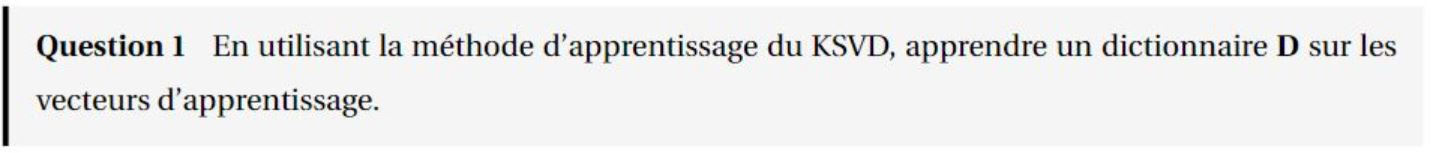

In [ ]:
Z = pd.read_excel(data, 'data_train', nrows=98)
Z = Z.to_numpy()

In [ ]:
# Initialisation du dictionnaire
E = Z
L = np.arange(K)
A = np.arange(K-1)
Alph = np.eye(K, l)
alphaZero = []
# Lancement de l'algorithme
for k in range(K):
    # <-- On enlève ce k-ème atome et on le met dans A pour sommer E sans prendre k en compte -->
    A = np.delete(L, k)

    # <-- Résolution du Lambda avec l'OMP -->
    for i in range(l):
        Alph[:, i] = OMP(D0, X[:, i], EPS, MAX_ITER)

    # <-- Calcul de l'erreur |X - D@Alph| après avoir enlevé le k-ème atome -->
    for i in A:
        E = E - D0[:, i].reshape(N, 1)@Alph[i, :].reshape(1, l)

    # <-- Recherche du nombre et les indices des exemples qui utilisent le k-ème atome -->
    W = np.count_nonzero(Alph[k, :])
    I = [i for i, e in enumerate(Alph[k, :]) if e != 0]

    # <-- Construction de la matrice Omega -->
    Omega = np.zeros((l, W))

    # <-- Remplissage de la matrice Omega -->
    for g in range(0, W):
        Omega[I[g], g] = 1  
        
    # <-- Calcul de E_r -->
    E_r = E @ Omega
    
    # <-- Application du K-SVD -->
    u, s, vh = np.linalg.svd(E_r)
    D0[:, k] = u[:, 0]
    
    if (W == 0):
        alphaZero = alphaZero + [k]
        E = Z
        continue
        
    # <-- Mise à jour des composantes non nulles de Alpha[i, :] -->
    C = np.zeros((W, 1))
    C[:, 0] = s[0]*vh[:, 0]
    for i, j in zip(I, range(len(C))):
        Alph[k, :][i] = C[j]
    
    #  <-- Réinitialisation E -->
    E = Z
    
    # <-- Remise de k dans A -->
    A = np.append(L, k)

In [ ]:
D0

array([[9.86627857e-01, 2.72483034e-02, 0.00000000e+00, ...,
        1.06713809e-01, 1.03587586e-01, 9.63952012e-02],
       [1.79957833e-03, 2.04380716e-02, 3.12015103e-05, ...,
        1.05167609e-01, 1.03675208e-01, 9.72840810e-02],
       [5.10741654e-03, 2.66144375e-02, 0.00000000e+00, ...,
        1.05504838e-01, 1.02252402e-01, 9.48863969e-02],
       ...,
       [1.68649483e-02, 2.70353796e-02, 1.07550414e-01, ...,
        1.03689832e-01, 1.05014070e-01, 1.09173755e-01],
       [2.25779473e-02, 2.71356716e-02, 1.19903955e-01, ...,
        1.06795182e-01, 7.68210954e-02, 1.08693626e-01],
       [1.71861803e-02, 1.84116926e-02, 1.19163156e-01, ...,
        1.07152810e-01, 7.99228793e-02, 1.07567933e-01]])

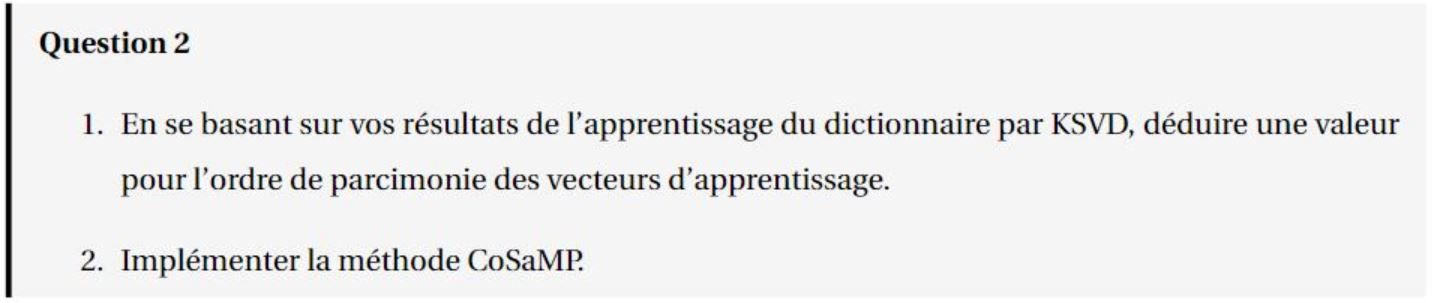

On répondra aux questions **(1)** et **(2)** à partir de la 
fonction ci-dessous. Cette dernière va **(1)** estimer l'ordre de parcimonie, **(2)** implementer la méthode **CoSaMP** et **(3)** comparer **(a)** le **signal approximé $\tilde{x_i}$** par l'apprentissage du dictionnaire et **(b)** le signal original $x_i$.

**Pour de raisons d'organisation, on ne peut pas afficher tous les signaux. On va se contenter des 3 premiers signaux.**

In [ ]:
def implementCompare(func, k, X, Alph):
    s = np.count_nonzero(Alph[:, k])
    if (func == CoSaMP):
        if (s == 0):
            s = 1
        X_approx = D0 @ func(D0, X[:, k], MAX_ITER, EPS, s).reshape(K, 1)
    else:
        X_approx = D0 @ func(D0, X[:, k], MAX_ITER, EPS).reshape(K, 1)
    x_ = np.arange(len(X_approx))
    fig, axs = plt.subplots(2, figsize=(15, 5))
    axs[0].set_title('Signal original')
    axs[0].plot(x_, X[:, k], 'tab:red')
    axs[1].set_title('Signal approximé')
    axs[1].plot(x_, X_approx, 'tab:green')

#### $\text{Graphique pour le signal (1)}$

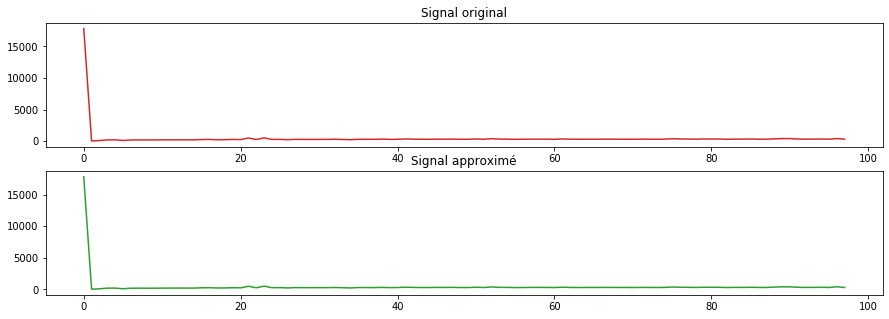

In [ ]:
implementCompare(CoSaMP, 0, X, Alph)

#### $\text{Graphique pour le signal (2)}$

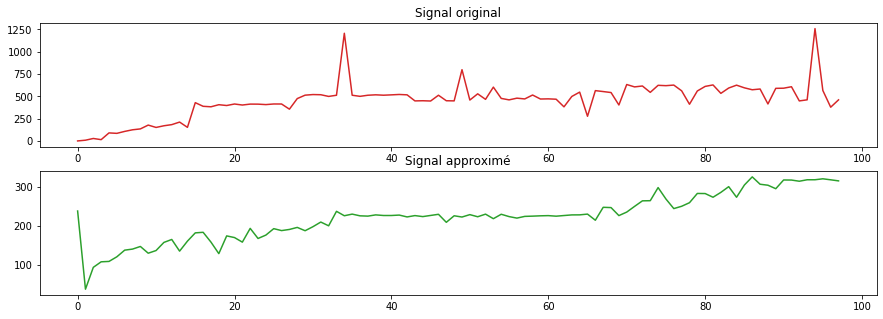

In [ ]:
implementCompare(CoSaMP, 1, X, Alph)

#### $\text{Graphique pour le signal (3)}$

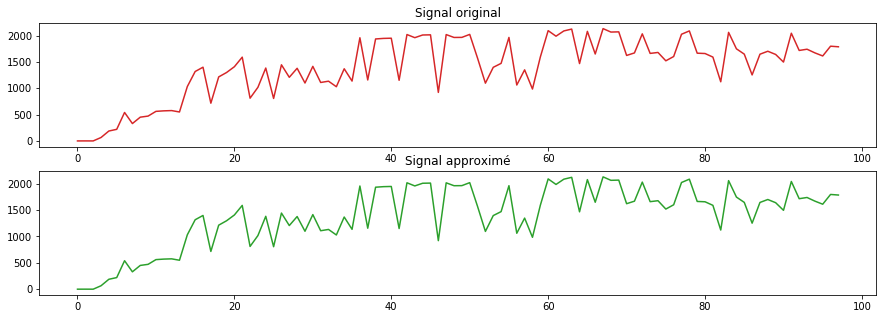

In [ ]:
implementCompare(CoSaMP, 2, X, Alph)

On remarque que le signal **(1)** et **(2)** est récupéré *(sans réduction)*. Cependant, on remarque des erreurs au niveau du signal **(2)** récupéré *(sans réduction)*. Cela peut être à cause d'un manque d'information, **on aura alors besoin de plus de données pour optimiser notre dictionnaire en faisant attention au sur-apprentissage**.

On observe aussi qu'il y a deux problèmes qui sont comme suit:

1) **L'ordinateur arrondit des valeurs $\approx 0$ par $0$**, cela implique que de l'estimation de $s$ devient erronée pour $15
/150$ signaux. Ainsi, on ne pourra pas lancer le CoSaMP avec une valeur nulle de $s$.

In [ ]:
s = 0
for k in range(0, 150):
    if (np.count_nonzero(Alph[:, k]) == 0):
        s = s + 1
print("Nombre de signaux arrondits: ", s)

Nombre de signaux arrondits:  15


2) Le deuxième problème rencontré se trouve dans l'inversibilité de $\Phi^T \Phi$ lors de l'estimation de la solution. La solution est d'utiliser une **pseudo-inverse** à la place.

### $\text{Essayons de faire la même chose avec l'OMP pour voir s'il y aura une différence.}$

#### $\text{Graphique pour le signal (1)}$

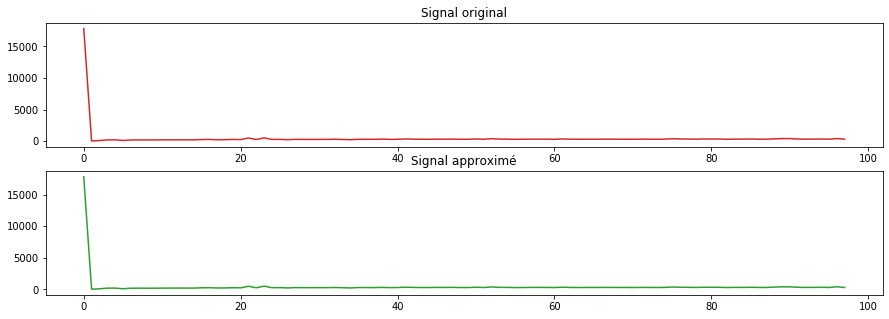

In [ ]:
implementCompare(OMP, 0, X, Alph)

#### $\text{Graphique pour le signal (2)}$

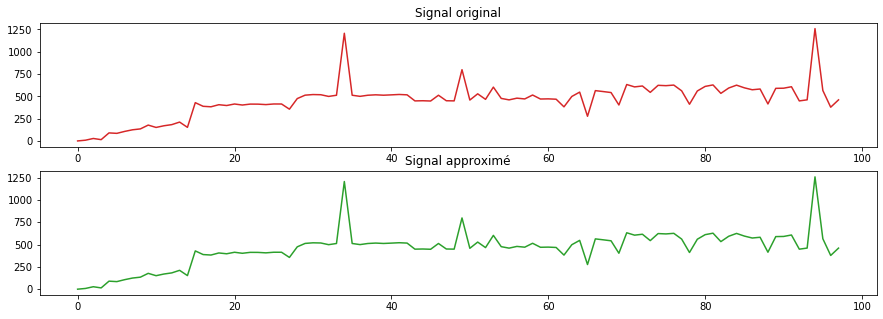

In [ ]:
implementCompare(OMP, 1, X, Alph)

#### $\text{Graphique pour le signal (3)}$

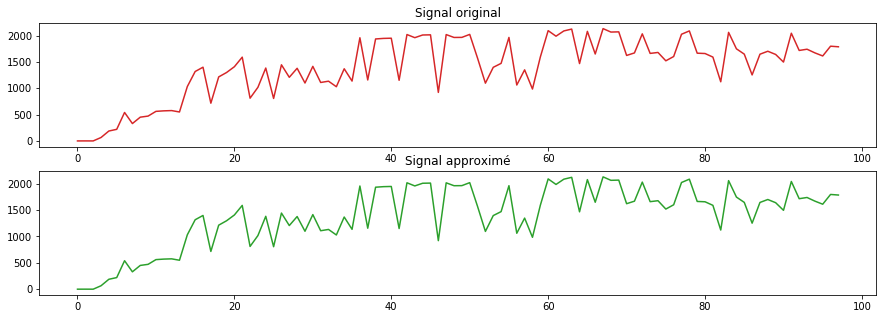

In [ ]:
implementCompare(OMP, 2, X, Alph)

On ne remarque pas de différence dans le signal **(1)** et **(3)**. Par contre, la précision a augmenté dans le signal **(2)**.

# $\text{Réduction}$

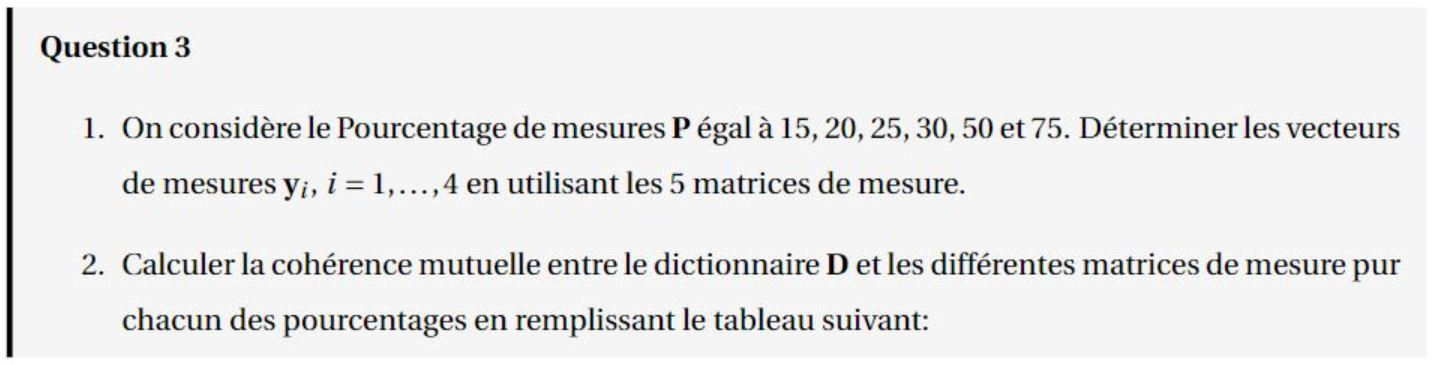

## $\text{Calcul des matrices de réduction}$

In [ ]:
def getM(P):
    M = []
    for k in range(0, len(P)):
        M = M +  [int(P[k]/100*N)]
    return M

In [ ]:
M = getM([15, 20, 25, 30, 50, 75])

In [ ]:
def reduceGamma(id, M, N):
    p = 0.6
    reducedGamma = np.zeros((M, N))
    
    # <-- (1) uniform réduction matrix -->
    if (id == 1): 
        reducedGamma = np.random.uniform(0, 1, size=(M, N))
        
    # <-- (2) bernoulli {-1, 1} réduction matrix -->    
    elif (id == 2):
        for k in range(M):
            for l in range(N):
                if np.random.uniform(0, 1) < p:
                    reducedGamma[k, l] = -1
                else:
                    reducedGamma[k, l] = 1
                    
    # <-- (3) bernoulli {0, 1} réduction matrix -->                   
    elif (id == 3):
        reducedGamma = np.random.binomial(1, p, size=(M, N))
        
    # <-- (4) gaussian réduction matrix -->  
    elif (id == 4):
        reducedGamma = np.random.normal(0, 1/M, size=(M,N))
        
    # <-- (5) sparse réduction matrix -->  
    elif (id == 5):
        reducedGamma = sc.random(M, N, density=0.25, random_state=2906)
        reducedGamma = reducedGamma.A  # transformation en array
        
    return(reducedGamma)

## $\text{Calcul des vecteurs de mesure}$ $y_i; i \in \{1, 2, 3, 4\}$

In [ ]:
def reduceSigs(D, X, M, j):
    N, K = D.shape
    reducedSigs = {}
    for m in M:
        reducedGamma = np.zeros((m, N))
        for k in range(1, 6):
            reducedGamma = reduceGamma(k, m, N)
            reducedSigs[(m, k)] = reducedGamma @ X[:, j]
    return reducedSigs

In [ ]:
# <-- vecteur de mesure (1) -->
reducedSig1 = reduceSigs(D0, X, M, 1)

# <-- vecteur de mesure (2) -->
reducedSig2 = reduceSigs(D0, X, M, 2)
 
# <-- vecteur de mesure (3) -->
reducedSig3 = reduceSigs(D0, X, M, 3)

# <-- vecteur de mesure (4) -->
reducedSig4 = reduceSigs(D0, X, M, 4)

## $\text{Calcul de la cohérence mutuelle}$

In [ ]:
def mutualCoherences(D, M):
    N, K = D.shape
    dictResult = {}
    for m in M:
        reducedGamma = np.zeros((m, N))
        for k in range(1, 6):
            choice = list()
            reducedGamma = reduceGamma(k, m, N)
            for l in range(m):
                for s in range(0, K):
                    if l != s:    
                        scal = abs(reducedGamma[l, :] @ D[:, s])
                        scal = scal/(np.linalg.norm(D[:, s])*np.linalg.norm(reducedGamma[l, :]))
                        choice.append(scal)
            dictResult[(m, k)] = np.sqrt(N)*max(choice)      
    return dictResult

In [ ]:
dictResult = mutualCoherences(D0, M)
values = dictResult.values()
labels = dictResult.keys()

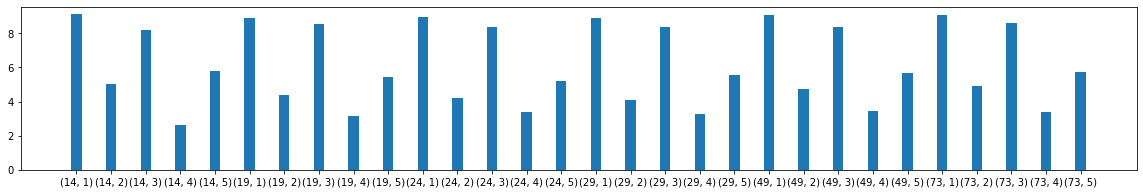

In [ ]:
plt.figure(figsize=(20, 3))
plt.bar(range(len(values)), list(values), width=0.3)
plt.xticks(range(len(values)), list(labels))
plt.show()

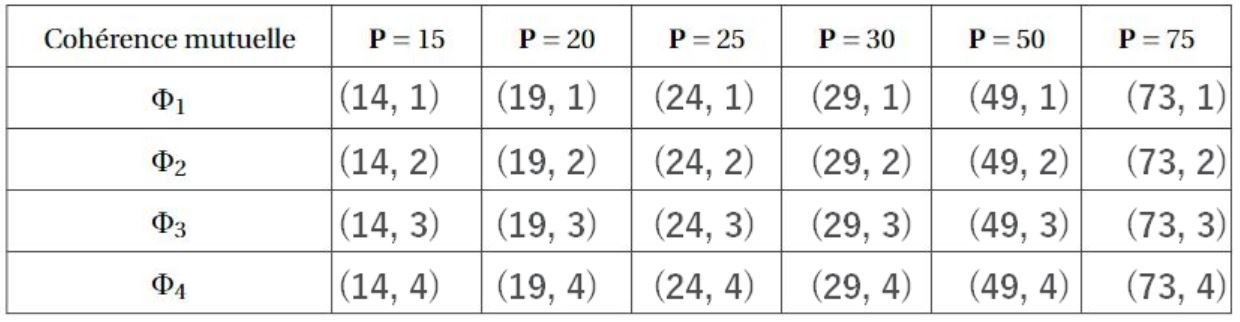

**On remarque qu'on obtient une cohérence mutuelle relativement faible pour les matrices de mesure $\Phi_2(m)$ et $\Phi_4(m); \forall m \in M$.**

# $\text{Récupération des signaux}$

## $\text{Importation des données}$

In [ ]:
X_TEST = pd.read_excel(data, 'data_test')
X_TEST = X_TEST.to_numpy()

## $\text{Calcul des vecteurs de mesure}$

In [ ]:
# <-- vecteur de mesure TEST (1) -->
reducedSig1 = reduceSigs(D0, X_TEST, M, 1)

# <-- vecteur de mesure TEST (2) -->
reducedSig2 = reduceSigs(D0, X_TEST, M, 2)

# <-- vecteur de mesure TEST (3) -->
reducedSig3 = reduceSigs(D0, X_TEST, M, 3)

### $\text{Calcul de  $ A = \Phi_M D$ pour $P \in [15, 20, 25, 30, 50, 75]$}$

In [ ]:
def reduceDicts(D, M):
    N, K = D.shape
    reducedDicts = {}
    for m in M:
        reducedGamma = np.zeros((m, N))
        for k in range(1, 6):
            reducedGamma = reduceGamma(k, m, N)
            reducedDicts[(m, k)] = reducedGamma @ D
    return reducedDicts

In [ ]:
reducedDicts = reduceDicts(D0, M)

### $\text{Résolution de }$ $\alpha_{k_{id}}(j_{signal}); k_{id} \in \{1, 2, 3, 4\}, j_{signal} \in \{1, 2, 3\}$

In [ ]:
def solveAlphas(reducedDicts, reducedSigs, func):
    alphasDict = {}
    EPS = 1e-3
    MAX_ITER = 25
    for k in reducedDicts.keys():
        if (func == StOMP or func == CoSaMP):         
            try:
                alphasDict[k] = func(reducedDicts[k], reducedSigs[k], EPS, MAX_ITER, 1)
            except Exception:
                pass
            continue
        alphasDict[k] = func(reducedDicts[k], reducedSigs[k], EPS, MAX_ITER)
    return alphasDict

In [ ]:
def solveAllAlphas(reducedDicts, reducedSigs):   
    pursuitAlgs = [MP, OMP, StOMP, CoSaMP]
    allAlphas = {}
    for i in pursuitAlgs:
        allAlphas[i] = solveAlphas(reducedDicts, reducedSigs, i)
    return allAlphas

In [ ]:
# <-- calcul des "alphas" vecteurs TEST (1) par OMP -->
alphasSig1 = solveAlphas(reducedDicts, reducedSig1, OMP)

# <-- calcul des "alphas" vecteurs TEST (2) par OMP -->
alphasSig2 = solveAlphas(reducedDicts, reducedSig2, OMP)

# <-- calcul des "alphas" vecteurs TEST (3) par OMP -->
alphasSig3 = solveAlphas(reducedDicts, reducedSig3, OMP)

In [ ]:
# <-- calcul des "alphas" vecteursTEST (1) par toutes les méthodes -->
allAlphasSig1 = solveAllAlphas(reducedDicts, reducedSig1)

# <-- calcul des "alphas" vecteurs TEST (2) par toutes les méthodes -->
allAlphasSig2 = solveAllAlphas(reducedDicts, reducedSig2)

# <-- calcul des "alphas" vecteurs TEST (3) par toutes les méthodes -->
allAlphasSig3 = solveAllAlphas(reducedDicts, reducedSig3)

### $\text{Récupération des signaux approximées pour chaque matrice}$ $\Phi(k) \ \forall k \in \{1, 2, 3, 4\}$

In [ ]:
def retrieveApprox(allAlphasDict, D):
    pursuitAlgs = [MP, OMP, StOMP, CoSaMP]
    allApproxSig = {}
    approxSig = {}
    for k in pursuitAlgs:
        for i in allAlphasDict[k].keys():
            approxSig[i] = D @ allAlphasDict[k][i]
        allApproxSig[k] = approxSig
        approxSig = {}
    return allApproxSig

In [ ]:
# <-- calcul de l'approximation du signal TEST (1) par toutes les méthodes -->
allApproxSig1 = retrieveApprox(allAlphasSig1, D0)

# <-- calcul de l'approximation du signal TEST (2) par toutes les méthodes -->
allApproxSig2 = retrieveApprox(allAlphasSig2, D0)

# <-- calcul de l'approximation du signal TEST (3) par toutes les méthodes -->
allApproxSig3 = retrieveApprox(allAlphasSig3, D0)

In [ ]:
# <-- regroupement des approximations dans une liste -->
allApproxSigs = [allApproxSig1, allApproxSig2, allApproxSig3]

# $\text{Visualisation des erreurs au niveau des signaux "TEST" approximés}$

In [ ]:
def graphCompare(X_approx, k):
    cases = [(14, 2), (24, 2), (73, 2), (14, 4), (19, 4), (24, 4)]
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:gray', 'tab:purple', 'tab:orange', 'tab:brown']
    x_ = np.arange(len(X_approx[(14, 2)]))
    fig, axs = plt.subplots(7, figsize=(15, 12), sharex=True)
    axs[0].set_title('Signal original')
    axs[0].plot(x_, X[:, k], colors[0])
    for i, j in zip(cases, range(1, 7)):
        try:
            axs[j].set_title('Signal approximé pour ID = {} et dimension de réduction M = {}'.format(i[1], i[0]))
            axs[j].plot(x_, X_approx[i], colors[j])
        except Exception:
            continue

Dans cette partie, on **utilisera notre dictionnaire $D_0$ appris dans la base d'apprenstissage** pour **récupérer des examples réduits de la base d'évaluation** où $D_0$ n'a pas été entrainé.

On va choisir *(choix aléatoire, on peut modifier le code pour visualiser d'autres signaux)* de visualiser l'erreur au niveau du signal **(2)**, **(3)** et **(4)**. Pour les matrices de réduction, on va choisir $\Phi_2$ et $\Phi_4$ qui minimisent la cohérence mutuelle.

#### $\text{Graphique pour le signal (2)}$

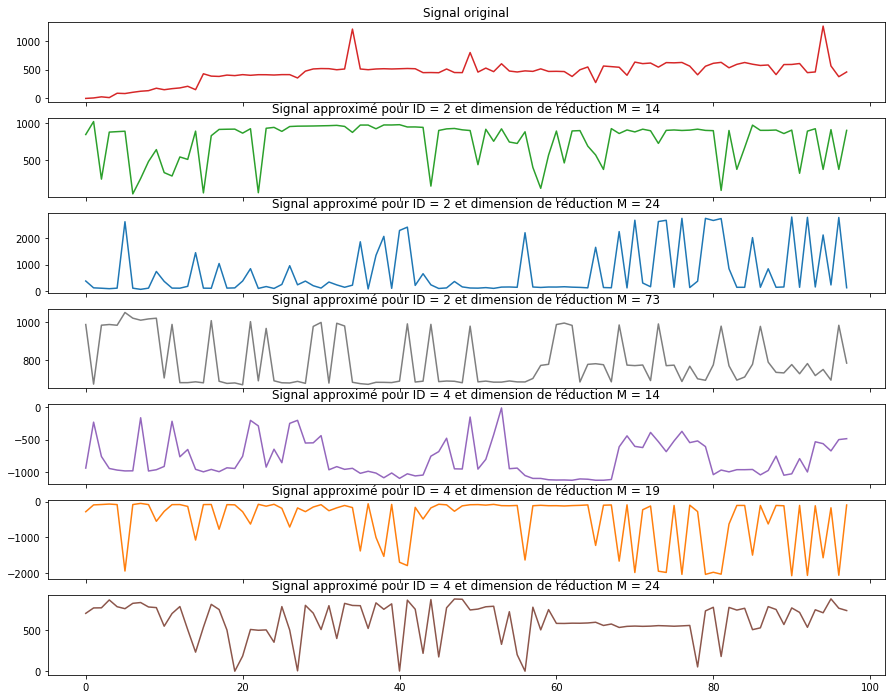

In [ ]:
# Méthode MP
graphCompare(allApproxSig1[MP], 1)

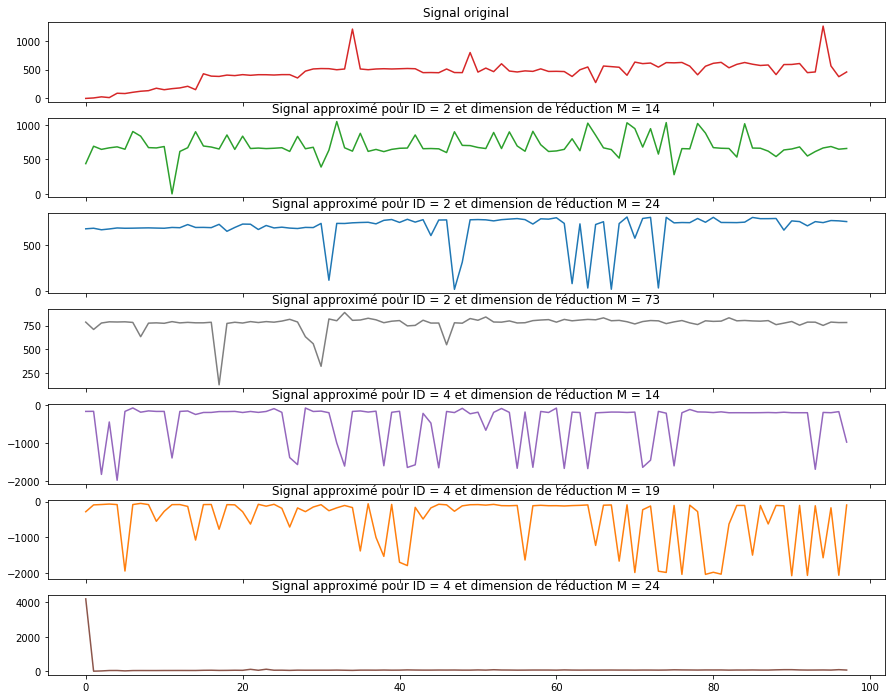

In [ ]:
# Méthode OMP
graphCompare(allApproxSig1[OMP], 1)

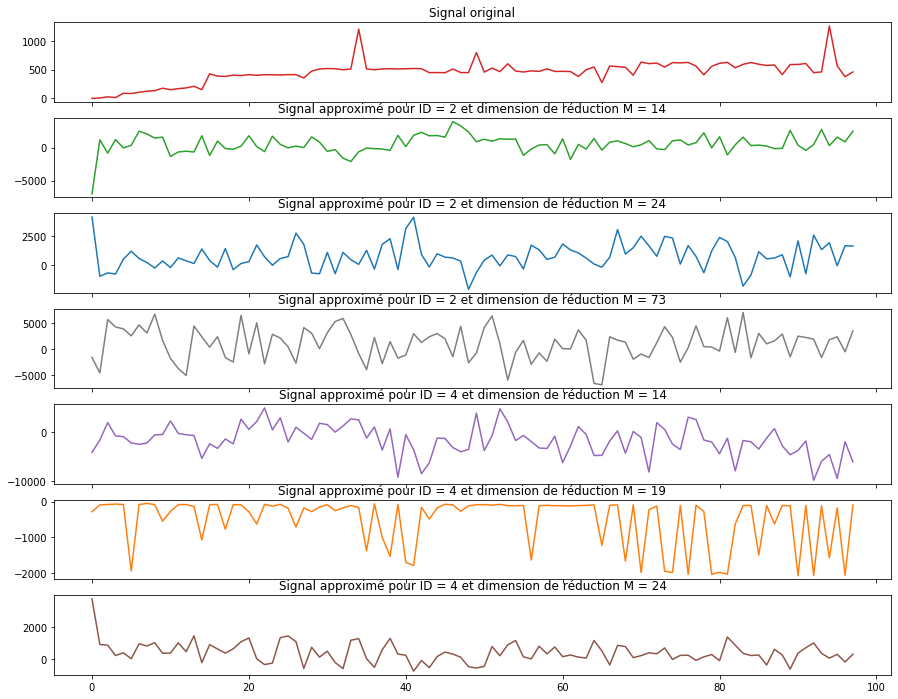

In [ ]:
# Méthode StOMP
graphCompare(allApproxSig1[StOMP], 1)

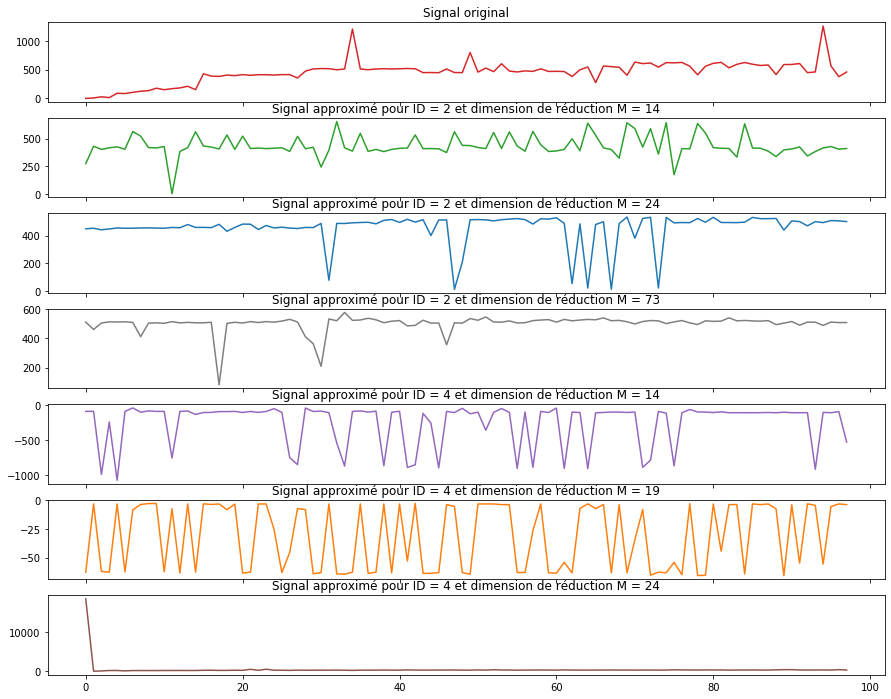

In [ ]:
# Méthode CoSaMP
graphCompare(allApproxSig1[CoSaMP], 1)

#### $\text{Graphique pour le signal (3)}$

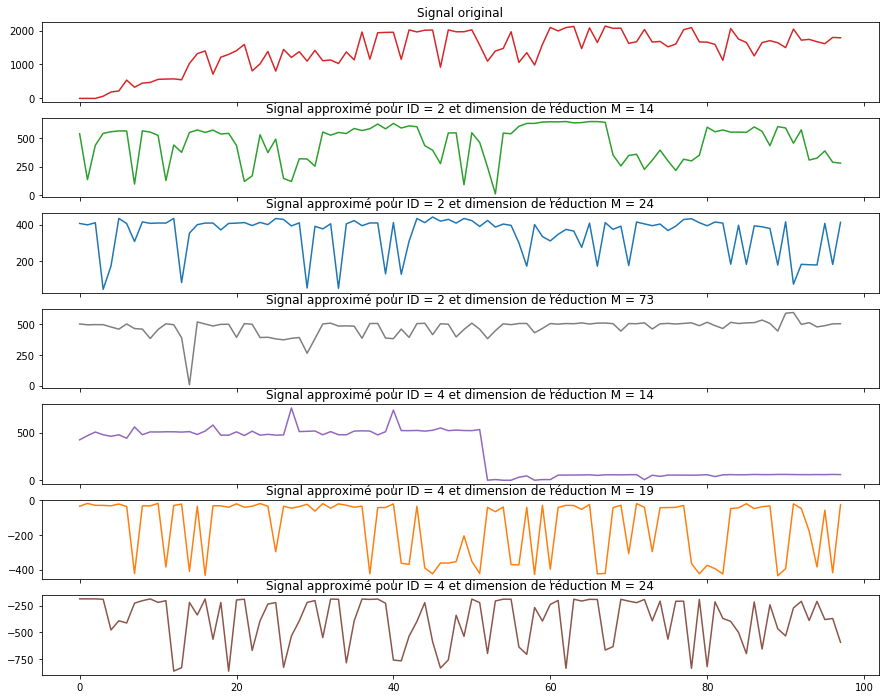

In [ ]:
# Méthode MP
graphCompare(allApproxSig2[MP], 2)

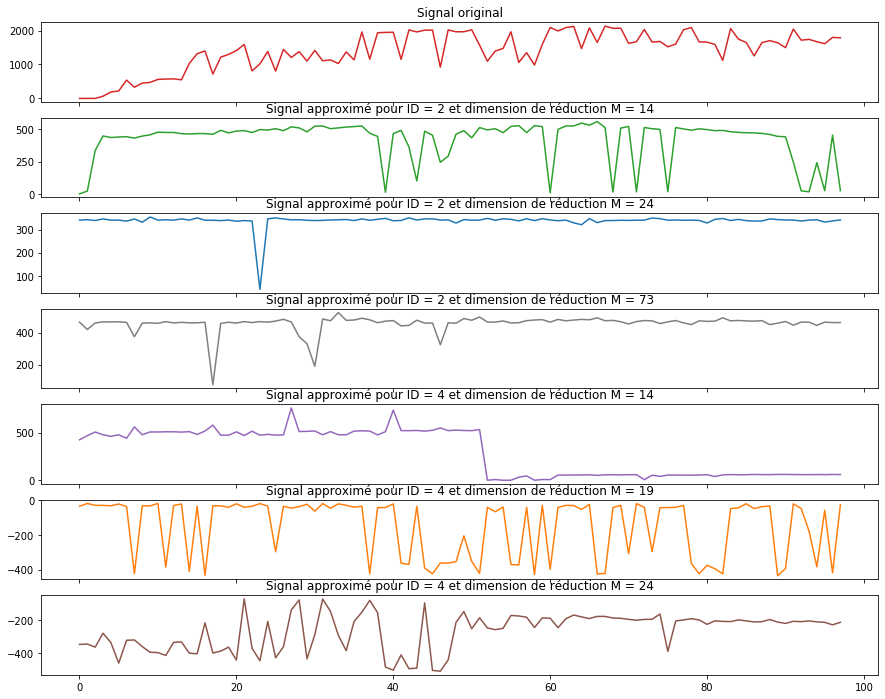

In [ ]:
# Méthode OMP
graphCompare(allApproxSig2[OMP], 2)

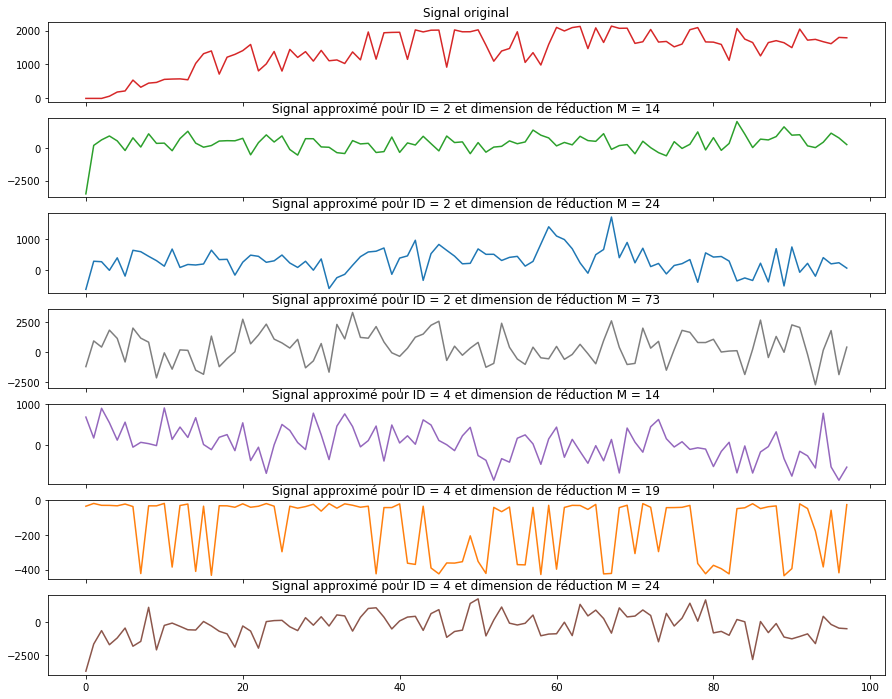

In [ ]:
# Méthode StOMP
graphCompare(allApproxSig2[StOMP], 2)

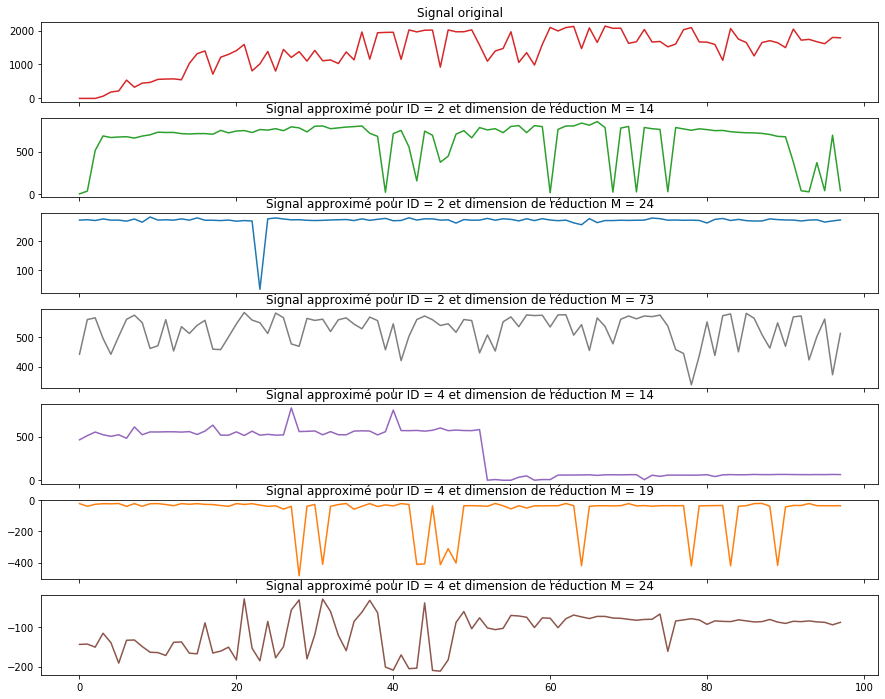

In [ ]:
# Méthode CoSaMP
graphCompare(allApproxSig2[CoSaMP], 2)

#### $\text{Graphique pour le signal (4)}$

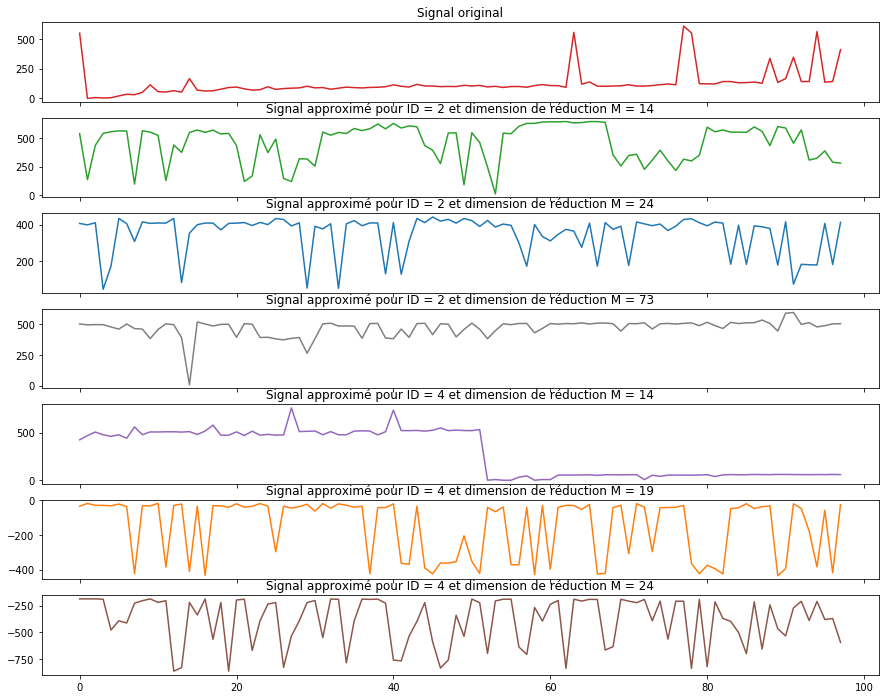

In [ ]:
# Méthode MP
graphCompare(allApproxSig2[MP], 4)

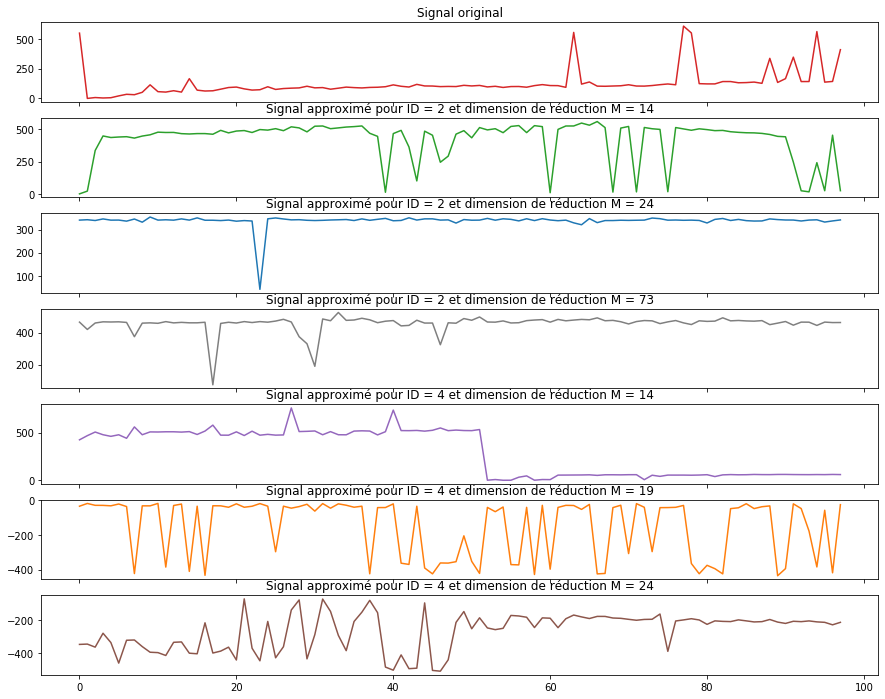

In [ ]:
# Méthode OMP
graphCompare(allApproxSig2[OMP], 4)

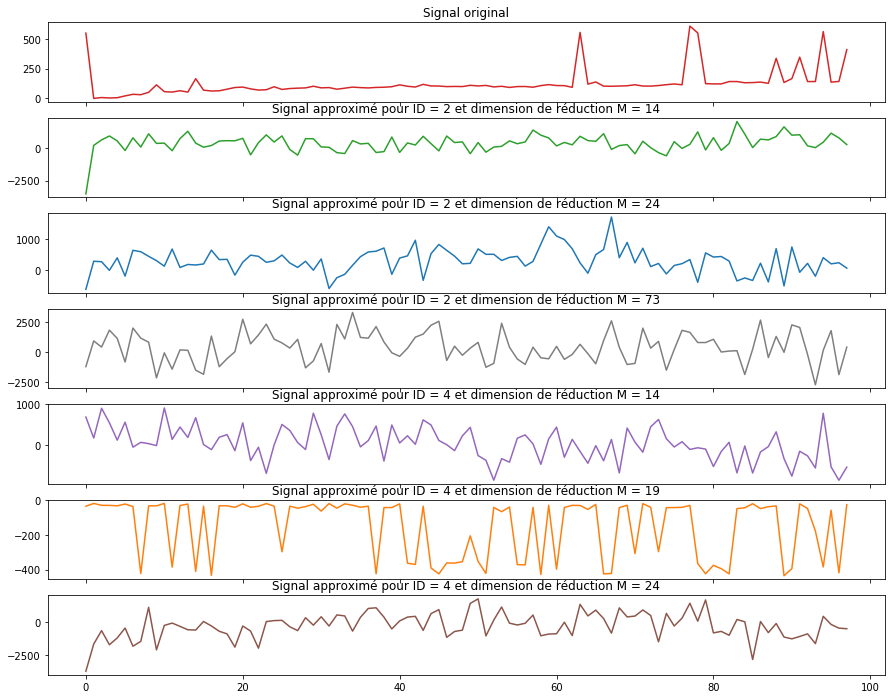

In [ ]:
# Méthode StOMP
graphCompare(allApproxSig2[StOMP], 4)

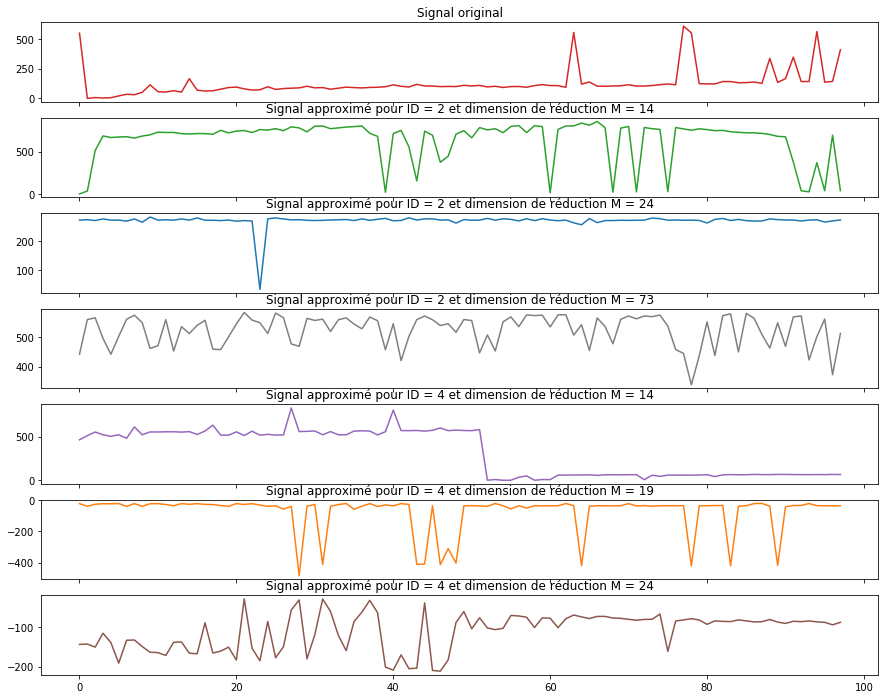

In [ ]:
# Méthode CoSaMP
graphCompare(allApproxSig2[CoSaMP], 4)

**On remarque qu'en général $\Phi_2$ récupère mieux les signaux que $\Phi_4$. Aussi, en moyenne, le MP et l'OMP possèdent une précision meilleure que StOMP et CoSaMP.**

# $\text{Conclusion}$

On remarque que le modèle, ne **sous-généralise** *(underfit)* pas beaucoup; cela a été démontré à travers la **question $2$**.

Cependant, lors de l'évaluation de notre modèle sur une nouvelle base **TEST**, on a remarqué qu'on a commis des erreurs. Ces mêmes erreurs étaient plus prononcées pour la matrice de réduction $\phi_4$ et pour les méthodes **StOMP** et **CoSaMP** qui nécessitent un calibrage plus optimal des paramètres respectifs $s$ et $t$.

Il est alors probable qu'on a **sur-généralisé** ou que la quantité de données n'est pas suffisante pour optimiser notre dictionnaire et avoir une meilleure précision.